In [1]:
import pickle
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import pairwise_distances

import os
os.chdir('../../')
from clustering_evaluation import ClusterPurity
evaluator=ClusterPurity()

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PATH_DISTMULT_E = 'Dataset/distmult_fb15k_256dim.pkl'

In [4]:
BASE_PATH_TRUTH = 'Dataset/Release'

# Load pre-trained KG model:

In [5]:
with open(PATH_DISTMULT_E, "rb") as fin:
    model = pickle.load(fin)
    
entity2id = model.graph.entity2id
relation2id = model.graph.relation2id

entity_embeddings = model.solver.entity_embeddings
relation_embeddings = model.solver.relation_embeddings

entity_embeddings.shape

(14951, 256)

## Get ground-truth from FB dataset:

In [6]:
fb_train=pd.read_csv(BASE_PATH_TRUTH + '/train.txt', sep='\t', header=None, index_col=0)
fb_valid=pd.read_csv(BASE_PATH_TRUTH + '/valid.txt', sep='\t', header=None, index_col=0)
fb_test=pd.read_csv(BASE_PATH_TRUTH + '/test.txt', sep='\t', header=None, index_col=0)

fb_df=pd.concat([fb_train, fb_valid, fb_test])
fb_df['type']= fb_df[1].apply(lambda x: x.split('/')[1])

In [7]:
fb_df['type']

0
/m/027rn          location
/m/017dcd               tv
/m/07s9rl0    media_common
/m/01sl1q            award
/m/0cnk2q           soccer
                  ...     
/m/0l5yl            people
/m/01z5tr           people
/m/0p5mw             music
/m/0727h          military
/m/050r1z             film
Name: type, Length: 310116, dtype: object

## Get Types for FB15k entities:

In [8]:
ground_truth={}
for entity_id in entity2id.keys():
    if entity_id in fb_df.index:
        if isinstance(fb_df.loc[entity_id, 'type'], pd.core.series.Series): 
            ground_truth[entity_id]=fb_df.loc[entity_id, 'type'][0]
        else:
            ground_truth[entity_id]=fb_df.loc[entity_id, 'type']
    else:
        ground_truth[entity_id]='unknown' # for missed types

In [9]:
# count frequent types in ground_truth
from collections import Counter
Counter(ground_truth.values()).most_common()

[('award', 2552),
 ('people', 2184),
 ('film', 2158),
 ('location', 1472),
 ('unknown', 1060),
 ('music', 767),
 ('soccer', 693),
 ('common', 618),
 ('education', 617),
 ('base', 611),
 ('sports', 434),
 ('tv', 325),
 ('organization', 317),
 ('user', 161),
 ('business', 146),
 ('olympics', 137),
 ('government', 135),
 ('influence', 118),
 ('military', 67),
 ('media_common', 64),
 ('medicine', 55),
 ('language', 51),
 ('time', 43),
 ('travel', 42),
 ('dataworld', 28),
 ('ice_hockey', 28),
 ('food', 22),
 ('celebrities', 20),
 ('american_football', 18),
 ('baseball', 5),
 ('broadcast', 3)]

In [10]:
#filter top commen types
entity_embedding_filter=[]
y_true_filter=[]

top_types=['people', 'film', 'location', 'music', 'soccer', 'education']

for k, value in ground_truth.items():
    if value in top_types:        
        entity_embedding_filter.append(entity_embeddings[entity2id[k]])
        y_true_filter.append(value)

In [11]:
X_all = np.asarray(entity_embedding_filter)
X_all.shape

(7891, 256)

In [12]:
encoder = LabelEncoder()
y_all = encoder.fit_transform(y_true_filter)
labels = encoder.classes_.tolist()

## t-SNE Freebase visualization

In [13]:
X_2d = TSNE(random_state=42).fit_transform(X_all)

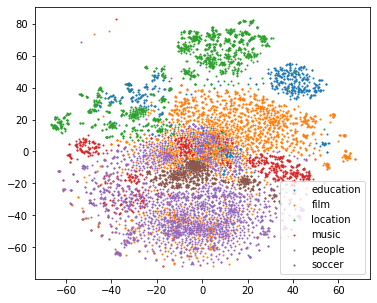

In [14]:
plt.figure(figsize=(6, 5))

label_ids = range(len(labels))
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[y_all == i, 0], X_2d[y_all == i, 1], c=c, label=label, s=1)

plt.legend()        
plt.savefig('./fb15k-distMult-full.png', dpi=600, bbox_inches='tight',pad_inches=0)
plt.show()

## Density-based Embeddings:

## HDBSCAN:

In [15]:
import hdbscan

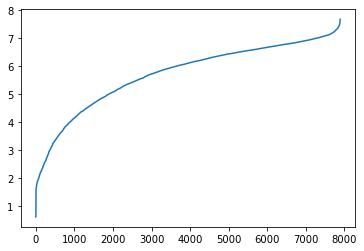

In [17]:
# final optimal value for cluster epsilon
neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(X_all)
distances, indices = nbrs.kneighbors(X_all)

distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)

In [16]:
X_all_double=X_all.astype(np.double)

In [17]:
%%time
hdbscan_clusterer=hdbscan.HDBSCAN(algorithm='best', alpha=0.1, metric='precomputed', cluster_selection_method='leaf',
                                      min_samples=10, min_cluster_size=700, core_dist_n_jobs=-1,allow_single_cluster=True,
                                      cluster_selection_epsilon=7)

distance_matrix = pairwise_distances(X_all_double, metric='cosine')
hdbscan_clusterer.fit(distance_matrix)

y_hdbscan=hdbscan_clusterer.labels_
# majority voting per cluster
df_tmp = pd.DataFrame({'pred_hdbscan': y_hdbscan, 'y_all': y_all})
pred_hdbscan = df_tmp.groupby('pred_hdbscan').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

CPU times: user 6.23 s, sys: 1.41 s, total: 7.64 s
Wall time: 4.14 s


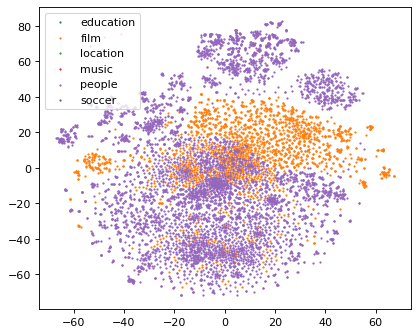

In [18]:
plt.figure(figsize=(6, 5), dpi=80)

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[pred_hdbscan == i, 0], X_2d[pred_hdbscan == i, 1], c=c, label=label, s=1)

plt.legend()        
plt.savefig('./fb15k-distMult-hdbscan.png', dpi=600, bbox_inches='tight',pad_inches=0)
plt.show()

In [19]:
print (len(set(pred_hdbscan)))

2


In [23]:
accuracy = accuracy_score(y_all, pred_hdbscan)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, pred_hdbscan, zero_division=0, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, pred_hdbscan, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, pred_hdbscan, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=pred_hdbscan))

Accuracy: 0.475098
Precision: 0.321258
Recall: 0.475098
F1 score: 0.362701
Purity:  0.47509821315422635


## Centroid-based Clustering (K-means):

In [19]:
%%time
kmeans = KMeans(n_clusters=len(top_types)).fit(X_all)
y_kmeans=kmeans.predict(X_all)

# majority voting per cluster
df_tmp = pd.DataFrame({'pred_kmeans': y_kmeans, 'y_all': y_all})
pred_kmeans = df_tmp.groupby('pred_kmeans').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

CPU times: user 13.3 s, sys: 408 ms, total: 13.7 s
Wall time: 955 ms


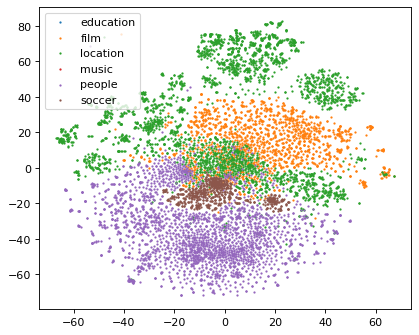

In [21]:
plt.figure(figsize=(6, 5), dpi=80)

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[pred_kmeans == i, 0], X_2d[pred_kmeans == i, 1], c=c, label=label, s=1)
    
plt.legend()
plt.savefig('./fb15k-distMult-Kmeans.png', dpi=600, bbox_inches='tight',pad_inches=0)
plt.show()

In [27]:
accuracy = accuracy_score(y_all, pred_kmeans)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, pred_kmeans, zero_division=0, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, pred_kmeans, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, pred_kmeans, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=pred_kmeans))

Accuracy: 0.771892
Precision: 0.750931
Recall: 0.771892
F1 score: 0.741956
Purity:  0.7718920288936764


## Agglomerative Clustering:

In [22]:
%%time
aggClustering = AgglomerativeClustering(n_clusters=len(top_types)).fit(X_all)
y_aggClustering=aggClustering.fit_predict(X_all)

# majority voting per cluster
df_tmp = pd.DataFrame({'pred_agglom': y_aggClustering, 'y_all': y_all})
pred_agglom = df_tmp.groupby('pred_agglom').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

CPU times: user 13.4 s, sys: 312 ms, total: 13.7 s
Wall time: 13.7 s


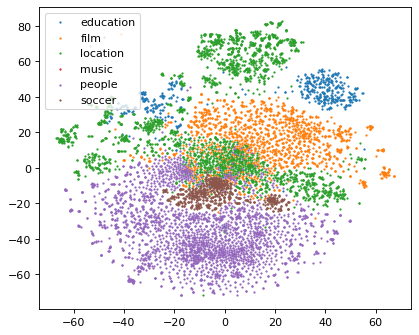

In [23]:
plt.figure(figsize=(6, 5), dpi=80)

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[pred_agglom == i, 0], X_2d[pred_agglom == i, 1], c=c, label=label, s=1)

plt.legend()
plt.savefig('./fb15k-distMult-agglom.png', dpi=600, bbox_inches='tight',pad_inches=0)
plt.show()


In [31]:
accuracy = accuracy_score(y_all, pred_agglom)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, pred_agglom, zero_division=0, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, pred_agglom, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, pred_agglom, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=pred_agglom))

Accuracy: 0.781523
Precision: 0.752827
Recall: 0.781523
F1 score: 0.749326
Purity:  0.7815232543403878


# Supervised Baselines:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.33, random_state=42)

In [33]:
projection_train = TSNE(random_state=42).fit_transform(X_train)
projection_test = TSNE(random_state=42).fit_transform(X_test)

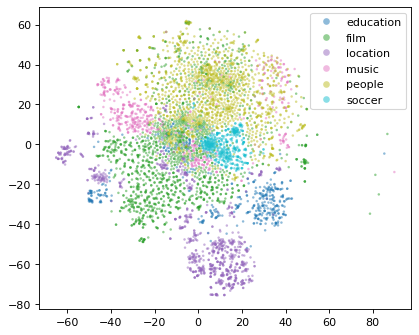

In [34]:
plt.figure(figsize=(6, 5), dpi=80)
scatter = plt.scatter(projection_train[:, 0], projection_train[:, 1], s=5,  cmap='tab10', c=y_train, linewidth=0, alpha=0.5) 

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)

plt.savefig('./fb15k-distMult-train.pdf', dpi=100)

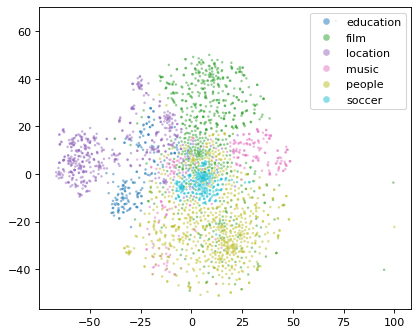

In [35]:
plt.figure(figsize=(6, 5), dpi=80)
scatter = plt.scatter(projection_test[:, 0], projection_test[:, 1], s=5,  cmap='tab10', c=y_test, linewidth=0, alpha=0.5) 

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)

plt.savefig('./fb15k-distMult-test.pdf', dpi=100)

## Logistic Regression:

In [20]:
%%time
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression(solver='liblinear',random_state=42).fit(X_train, y_train.ravel())
y_lr = logistic_clf.predict(X_test)

CPU times: user 1.07 s, sys: 3.56 ms, total: 1.07 s
Wall time: 1.05 s


In [36]:

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_lr)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_lr, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_lr, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_lr, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_lr))

Accuracy: 0.905566
Precision: 0.907112
Recall: 0.905566
F1 score: 0.905923
Purity Score:  0.9055662188099808


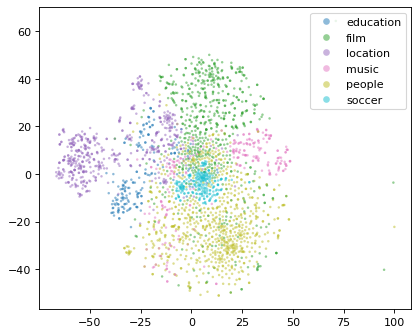

In [50]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_test[:, 0], projection_test[:, 1], s=5,  cmap='tab10', c=y_lr, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./fb15k-distMult-logistic.pdf', dpi=100)


## KNN:

In [21]:
%%time
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train.ravel())
y_knn = neigh.predict(X_test)

CPU times: user 6.64 s, sys: 30 µs, total: 6.64 s
Wall time: 6.64 s


In [39]:

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_knn)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_knn, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_knn, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_knn, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_knn))

Accuracy: 0.802303
Precision: 0.835671
Recall: 0.802303
F1 score: 0.798119
Purity Score:  0.8023032629558541


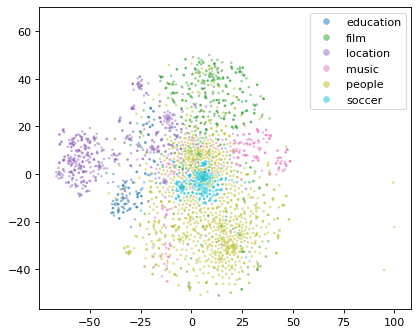

In [40]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_test[:, 0], projection_test[:, 1], s=5,  cmap='tab10', c=y_knn, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./fb15k-distMult-knn.pdf', dpi=100)


## RandomForest:

In [22]:
%%time
from sklearn.ensemble import RandomForestClassifier

random_clf = RandomForestClassifier(random_state=42).fit(X_train, y_train.ravel())
y_rf= random_clf.predict(X_test)

CPU times: user 7.2 s, sys: 4.02 ms, total: 7.21 s
Wall time: 7.21 s


In [41]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_rf)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_rf, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_rf, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_rf, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_rf))

Accuracy: 0.908253
Precision: 0.919670
Recall: 0.908253
F1 score: 0.908360
Purity Score:  0.9082533589251439


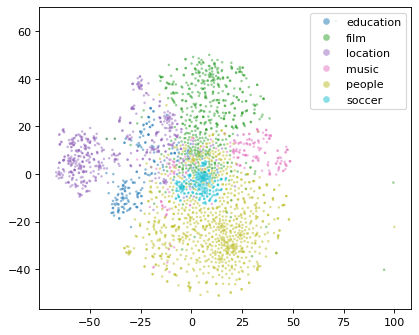

In [42]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_test[:, 0], projection_test[:, 1], s=5,  cmap='tab10', c=y_rf, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./fb15k-distMult-RandomForest.pdf', dpi=100)

# Random Clustering:

In [25]:
y_random=np.random.choice([0, 1,2,3,4,5], size=y_all.shape[0])

In [26]:
# majority voting per cluster
df_tmp = pd.DataFrame({'y_random': y_random, 'y_all': y_all})
y_random = df_tmp.groupby('y_random').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

In [27]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_all, y_random)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, y_random, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, y_random, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, y_random, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=y_random))

Accuracy: 0.287163
Precision: 0.158010
Recall: 0.287163
F1 score: 0.203845
Purity:  0.28716259029273855


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


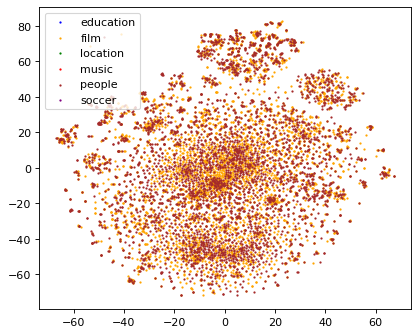

In [28]:
plt.figure(figsize=(6, 5), dpi=80)

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[y_random == i, 0], X_2d[y_random == i, 1], c=c, label=label, s=1)
    

plt.legend()
plt.savefig('./fb15k-distMult-random.pdf', dpi=100)


## Random Clustering based on Type Distribution:

In [29]:
weights=[]
y_counts=Counter(y_all)

for i in range(len(top_types)):
    weights.append(y_counts[i]/y_all.shape[0])
    
weights    

[0.07819034342922317,
 0.27347611202635913,
 0.1865416297047269,
 0.09719934102141681,
 0.27677100494233936,
 0.0878215688759346]

In [30]:
y_random_bala=np.random.choice([0,1,2,3,4,5], size=y_all.shape[0], p=weights)

In [31]:
# majority voting per cluster
df_tmp = pd.DataFrame({'y_random': y_random_bala, 'y_all': y_all})
y_random_bala = df_tmp.groupby('y_random').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

In [32]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_all, y_random_bala)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, y_random_bala, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, y_random_bala, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, y_random_bala, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=y_random_bala))

Accuracy: 0.280066
Precision: 0.154176
Recall: 0.280066
F1 score: 0.198439
Purity:  0.2800658978583196


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


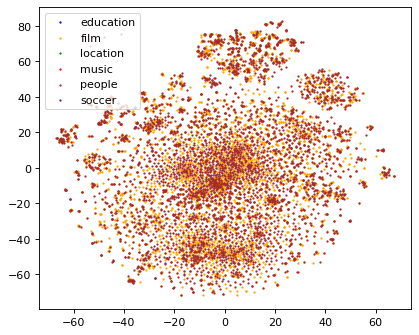

In [33]:
plt.figure(figsize=(6, 5), dpi=80)

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[y_random_bala == i, 0], X_2d[y_random_bala == i, 1], c=c, label=label, s=1)

plt.legend()
plt.savefig('./fb15k-distMult-randomBala.pdf', dpi=100)